# Cartpole optimal control problem

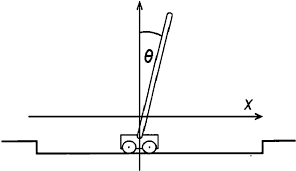

A cartpole is another classical example of control. In this system, an underactuated pole is attached on top of a 1D actuacted cart. The game is to raise the pole to a standing position.

The model is here:
https://en.wikipedia.org/wiki/Inverted_pendulum

We denote by $m_1$ the cart mass, $m_2$ the pole mass, $l$ the pole length, $\theta$ the pole angle w.r.t. the vertical axis, $x$ the cart position, and $g=$9.81 the gravity.

The system acceleration can be rewritten as:

$$\ddot{\theta} = \frac{1}{\mu(\theta)} \big( \frac{\cos \theta}{l} f + \frac{mg}{l} \sin(\theta) - m_2 \cos(\theta) \sin(\theta) \dot{\theta}^2\big),$$

$$\ddot{x} = \frac{1}{\mu(\theta)} \big( f + m_2 \cos(\theta) \sin(\theta) g -m_2 l \sin(\theta) \dot{\theta} \big),$$

$\hspace{12em}$with $$\mu(\theta) = m_1+m_2 \sin(\theta)^2,$$

where $f$ represents the input command.


## I. Differential Action Model

A Differential Action Model (DAM) describes the action (control/dynamics) in continous-time. In this exercise, we ask you to write the equation of motions for the cartpole.

For more details, see the instructions inside the DifferentialActionModelCartpole class.

In [1]:
import crocoddyl
import pinocchio
import numpy as np

class DifferentialActionModelCartpole(crocoddyl.DifferentialActionModelAbstract):
    def __init__(self):
        crocoddyl.DifferentialActionModelAbstract.__init__(self, crocoddyl.StateVector(4), 1, 6) # nu = 1; nr = 6
        self.unone = np.zeros(self.nu)

        self.m1 = 1.
        self.m2 = .1
        self.l  = .5
        self.g  = 9.81
        self.costWeights = [ 1., 1., 0.1, 0.001, 0.001, 1. ]  # sin, 1-cos, x, xdot, thdot, f
        
    def calc(self, data, x, u=None):
        if u is None: u=model.unone
        # Getting the state and control variables
        y, th, ydot, thdot = np.asscalar(x[0]), np.asscalar(x[1]), np.asscalar(x[2]), np.asscalar(x[3])
        f = np.asscalar(u[0])

        # Shortname for system parameters
        m1, m2, l, g = self.m1, self.m2, self.l, self.g
        s, c = np.sin(th), np.cos(th)

        # Defining the equation of motions
        m = m1 + m2
        mu = m1 + m2 * s**2
        xddot  = (f     + m2 * c * s * g - m2 * l * s * thdot**2 ) / mu
        thddot = (c * f / l + m * g * s / l  - m2 * c * s * thdot**2 ) / mu
        data.xout = np.matrix([ xddot,thddot ]).T

        # Computing the cost residual and value
        data.r = np.matrix(self.costWeights * np.array([ s, 1-c, y, ydot, thdot, f ])).T
        data.cost = .5* np.asscalar(sum(np.asarray(data.r)**2))

    def calcDiff(self,data,x,u=None,recalc=True):
        # Advance user might implement the derivatives
        pass

You may want to check your computation. Here is how to create the model and run the calc method.

In [2]:
cartpoleDAM = DifferentialActionModelCartpole()
cartpoleData = cartpoleDAM.createData()
x = cartpoleDAM.state.rand()
u = np.zeros(1)
cartpoleDAM.calc(cartpoleData, x, u)

## II. Write the derivatives with DAMNumDiff

In the previous exercise, we didn't define the derivatives of the cartpole system. In crocoddyl, we can compute them without any additional code thanks to the DifferentialActionModelNumDiff class. This class computes the derivatives through numerical differentiation.

In the following cell, you need to create a cartpole DAM that computes the derivates using NumDiff.

In [3]:
# Creating the cartpole DAM
cartpoleND = crocoddyl.DifferentialActionModelNumDiff(cartpoleDAM, True)

After creating your cartpole DAM with NumDiff. We would like that you answer the follows:

 - 2 columns of Fx are null. Wich ones? Why?

 - can you double check the values of Fu?


## III. Integrate the model

After creating DAM for the cartpole system. We need to create an Integrated Action Model (IAM). Remenber that an IAM converts the continuos-time action model into a discrete-time action model. For this exercise we'll use a simpletic Euler integrator.

In [4]:
timeStep = 5e-2
cartpoleIAM = crocoddyl.IntegratedActionModelEuler(cartpoleND, timeStep)

## IV. Write the problem, create the solver

First, you need to describe your shooting problem. For that, you have to indicate the number of knots and their time step. For this exercise we want to use 50 knots with $dt=$5e-2.

Here is how we create the problem.

In [5]:
# Fill the number of knots (T) and the time step (dt)
x0 = np.matrix([ 0., 3.14, 0., 0. ]).T
T  = 50
problem = crocoddyl.ShootingProblem(x0, [ cartpoleIAM ]*T, cartpoleIAM)

Problem cannot solve, just integrate:

In [6]:
us = [ pinocchio.utils.zero(cartpoleIAM.differential.nu) ]*T
xs = problem.rollout(us)

In cartpole_utils, we provite a plotCartpole and a animateCartpole methods.

In [7]:
%%capture
%matplotlib inline
from cartpole_utils import animateCartpole
anim = animateCartpole(xs)

# If you encounter problems probably you need to install ffmpeg/libav-tools:
# sudo apt-get install ffmpeg
# or
# sudo apt-get install libav-tools

And let's display this rollout!

Note that to_jshtml spawns the video control commands.

In [8]:
from IPython.display import HTML
# HTML(anim.to_jshtml())
HTML(anim.to_html5_video())

Now we want to create the solver (SolverDDP class) and run it. Display the result. **Do you like it?**

In [10]:
# Creating the DDP solver
ddp = crocoddyl.SolverDDP(problem)
ddp.setCallbacks([crocoddyl.CallbackVerbose()])

# Solving this problem
done = ddp.solve([], [], 1000)
print(done)
print(ddp.us)

True
[matrix([[ -8.94214276e-05]]), matrix([[-0.00029639]]), matrix([[-0.00047926]]), matrix([[-0.00062904]]), matrix([[-0.00073887]]), matrix([[-0.00080438]]), matrix([[-0.00082385]]), matrix([[-0.00079809]]), matrix([[-0.00073051]]), matrix([[-0.0006266]]), matrix([[-0.00049372]]), matrix([[-0.00034048]]), matrix([[-0.00017623]]), matrix([[ -1.05525455e-05]]), matrix([[ 0.0001474]]), matrix([[ 0.00028933]]), matrix([[ 0.00040825]]), matrix([[ 0.00049887]]), matrix([[ 0.00055779]]), matrix([[ 0.00058358]]), matrix([[ 0.00057683]]), matrix([[ 0.00053998]]), matrix([[ 0.00047702]]), matrix([[ 0.00039324]]), matrix([[ 0.00029483]]), matrix([[ 0.00018843]]), matrix([[  8.06566777e-05]]), matrix([[ -2.21837883e-05]]), matrix([[-0.00011458]]), matrix([[-0.00019208]]), matrix([[-0.00025149]]), matrix([[-0.000291]]), matrix([[-0.00031023]]), matrix([[-0.00031014]]), matrix([[-0.00029285]]), matrix([[-0.00026147]]), matrix([[-0.00021977]]), matrix([[-0.00017187]]), matrix([[-0.00012191]]), mat

In [11]:
%%capture
%matplotlib inline

# Create animation
anim = animateCartpole(ddp.xs)

In [12]:
# HTML(anim.to_jshtml())
HTML(anim.to_html5_video())

## Tune the problem, solve it

Give some indication about what should be tried for solving the problem.


 - Without a terminal model, we can see some swings but we cannot stabilize. What should we do?

 - The most important is to reach the standing position. Can we also nullify the velocity?

 - Increasing all the weights is not working. How to slowly increase the penalty?



In [13]:
###########################################################################
################## TODO: Tune the weights for each cost ###################
###########################################################################
terminalCartpole = DifferentialActionModelCartpole()
terminalCartpoleDAM = crocoddyl.DifferentialActionModelNumDiff(terminalCartpole, True)
terminalCartpoleIAM = crocoddyl.IntegratedActionModelEuler(terminalCartpoleDAM)

terminalCartpole.costWeights[0] = 100
terminalCartpole.costWeights[1] = 100
terminalCartpole.costWeights[2] = 1.
terminalCartpole.costWeights[3] = 0.1
terminalCartpole.costWeights[4] = 0.01
terminalCartpole.costWeights[5] = 0.0001
problem = crocoddyl.ShootingProblem(x0, [ cartpoleIAM ]*T, terminalCartpoleIAM)

In [15]:
# Creating the DDP solver
ddp = crocoddyl.SolverDDP(problem)
ddp.setCallbacks([ crocoddyl.CallbackVerbose() ])

# Solving this problem
done = ddp.solve([], [], 300)
print(done)

True


In [16]:
%%capture
%matplotlib inline

# Create animation
anim = animateCartpole(ddp.xs)

In [17]:
# HTML(anim.to_jshtml())
HTML(anim.to_html5_video())